# Installed Energy Capacity in Europe
Here we will find some data to see what the state of renewable energy production is within Europe.
The data is collected from:
https://transparency.entsoe.eu/generation/r2/installedGenerationCapacityAggregation/show

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

The data is collected via the script `scrape_data.py`. Here we load it all back in. For each country we have a dataframe of energy production capacities.

In [2]:
area_type = "CTY"
output_path = pathlib.Path(os.getcwd()) / "data" / area_type
country_names = [
    f.replace(".parquet", "")
    for f in os.listdir(output_path)
    if ".parquet" in f
]
country_names = sorted(country_names)

cap_tables = []
for country in country_names:
    cap_tables.append(pd.read_parquet(output_path / (country + ".parquet")))

### Quick inspection
We can see the contents of the dataframe for Germany. Each column is the type of the installed energy production:

In [3]:
idx = country_names.index('Germany (DE)')
cap_tables[idx]

Production Type,Fossil Peat,Nuclear,Fossil Hard coal,Wind Onshore,Fossil Brown coal/Lignite,Geothermal,Hydro Run-of-river and poundage,Hydro Water Reservoir,Wind Offshore,Hydro Pumped Storage,...,Solar,Fossil Oil shale,Waste,Fossil Gas,Fossil Coal-derived gas,Fossil Oil,Marine,Other,Biomass,Total Grand capacity
2015,NaN,12068.0,26190.0,37701.0,21160.0,34.0,3989.0,1518.0,993.0,8699.0,...,37271.0,NaN,1685.0,31734.0,NaN,4532.0,NaN,1220.0,6808.0,196051.0
2016,NaN,10793.0,26264.0,41168.0,21062.0,34.0,3996.0,1518.0,3283.0,8699.0,...,38686.0,NaN,1685.0,32398.0,NaN,4605.0,NaN,1286.0,6815.0,202803.0
2017,NaN,10793.0,27437.0,47042.0,21262.0,40.0,4007.0,1439.0,4131.0,8894.0,...,40834.0,NaN,1685.0,32627.0,NaN,4614.0,NaN,1421.0,7080.0,213816.0
2018,NaN,9516.0,25035.0,51633.0,21275.0,38.0,3860.0,1440.0,5051.0,8918.0,...,42804.0,NaN,1686.0,31361.0,NaN,4271.0,NaN,1418.0,7396.0,216198.0
2019,NaN,9516.0,25293.0,52792.0,21205.0,42.0,3983.0,1298.0,6393.0,9422.0,...,45299.0,NaN,1686.0,31664.0,NaN,4356.0,NaN,1235.0,7752.0,222381.0
2020,NaN,8114.0,22458.0,53405.0,21067.0,42.0,3958.0,1298.0,7709.0,9422.0,...,46471.0,NaN,1661.0,31712.0,0.0,4373.0,NaN,1558.0,7855.0,221584.0


### Largest capacity country
Which countries have the most energy capacity?

,Installed production (MW)
Germany (DE),212139.0
France (FR),126668.0
Spain (ES),105300.0
Italy (IT),96132.0
United Kingdom (UK),68215.0
Poland (PL),39418.0
Sweden (SE),38837.0
Netherlands (NL),32177.0
Norway (NO),30734.0
Belgium (BE),21894.0


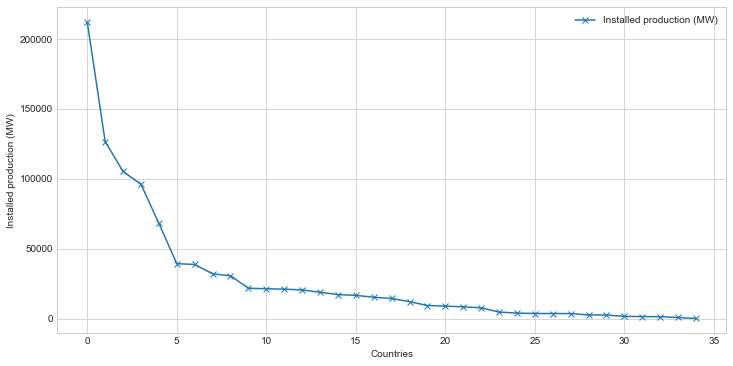

In [4]:
max_caps = np.array(
    [table["Total Grand capacity"].mean() for table in cap_tables]
)
max_cap = pd.DataFrame()
max_cap['Installed production (MW)'] = np.round(max_caps)
max_cap.index = country_names
max_cap = max_cap.sort_values(by='Installed production (MW)', ascending=False)
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Countries')
ax.set_ylabel('Installed production (MW)')
max_cap.plot(use_index=False, ax=ax, style='x-')
max_cap.head(10)

Germany in this dataset is much larger than other countries, and there is a fast fall off with the small countries.

### Renewables breakdown
We can plot all the countries summarised by a breakdown of renewables/fossil fuels. The countries are ordered by total installed energy production capacity.

In [5]:
# Split energy into renewables and fossil fuels
energy_types = []
for table in cap_tables:
    energy_types += list(table.columns)
energy_types = list(set(energy_types))

fossil_types = [
    energy_type for energy_type in energy_types if "Fossil" in energy_type
]
non_fossil_types = [
    energy_type for energy_type in energy_types if "Fossil" not in energy_type
]
non_fossil_types.remove("Total Grand capacity")

# define helper functions
def sum_renewables_table(df):
    df_sum = pd.DataFrame(index=df.index)
    df_sum["Fossil"] = df.loc[:, fossil_types].sum(axis=1)
    df_sum["Renewables"] = df.loc[:, non_fossil_types].sum(axis=1)
    df_sum[df_sum == 0] = np.nan
    return df_sum

def line_plot(df, ax, title):
    df.plot(ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, df.max().max() * 1.1)

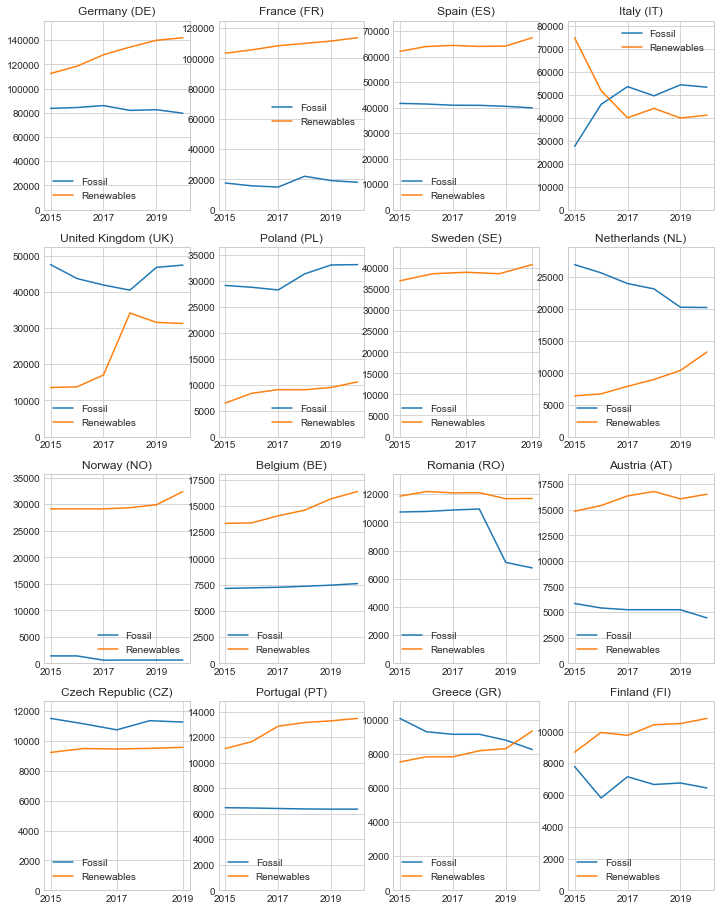

In [6]:
subplot_ncols = 4
subplot_nrows = 4 #int(np.ceil(len(cap_tables) / subplot_ncols))
fig, ax = plt.subplots(
    ncols=subplot_ncols, nrows=subplot_nrows, figsize=(12, 4 * subplot_nrows)
)
max_caps = np.array(
    [table["Total Grand capacity"].mean() for table in cap_tables]
)
max_caps[np.isnan(max_caps)] = -1
sort_idx = np.flip(np.argsort(max_caps))
for idx, table_idx in enumerate(sort_idx[:16]):
    try:
        line_plot(
            sum_renewables_table(cap_tables[table_idx]),
            ax[idx // subplot_ncols, idx % subplot_ncols],
            country_names[table_idx],
        )
    except:
        pass

Of the bigger countries - new energy capacity in Germany and France have been moving in the right direction, but the fossils have not reduced much. Italy has been moving in the wrong direction, installing more fossil fuels. The UK has also increased it capacity of fossil fuels.

## Production type breakdown
We can plot all production types together to see what has changed:

In [8]:
energy_groups = {
    "Biomass": "Other renewable",
    "Fossil Brown coal/Lignite": "Fossil Other",
    "Fossil Coal-derived gas": "Fossil Gas",
    "Fossil Gas": "Fossil Gas",
    "Fossil Hard coal": "Fossil Coal",
    "Fossil Oil": "Fossil Other",
    "Fossil Oil shale": "Fossil Other",
    "Fossil Peat": "Fossil Other",
    "Geothermal": "Other renewable",
    "Hydro Pumped Storage": "Hydro",
    "Hydro Run-of-river and poundage": "Hydro",
    "Hydro Water Reservoir": "Hydro",
    "Marine": "Other Renewable",
    "Nuclear": "Nuclear",
    "Other": "Other",
    "Other Renewable": "Other Renewable",
    "Solar": "Solar",
    "Waste": "Other Renewable",
    "Wind Offshore": "Wind",
    "Wind Onshore": "Wind",
}

def prep_table(df):
    temp = df.copy()
    # drop missing types
    temp2 = temp.isna().all(axis=0)
    temp = temp.drop(
        columns=list(temp2[temp2].index) + ["Total Grand capacity"]
    )

    # rename and combine columns
    temp = temp.rename(columns=energy_groups)
    for key in list(set(energy_groups.values())):
        try:
            temp2 = temp.loc[:, [key]].sum(axis=1)
            temp.drop(columns=key, inplace=True)
            temp[key] = temp2
        except:
            temp[key] = 0

    return temp

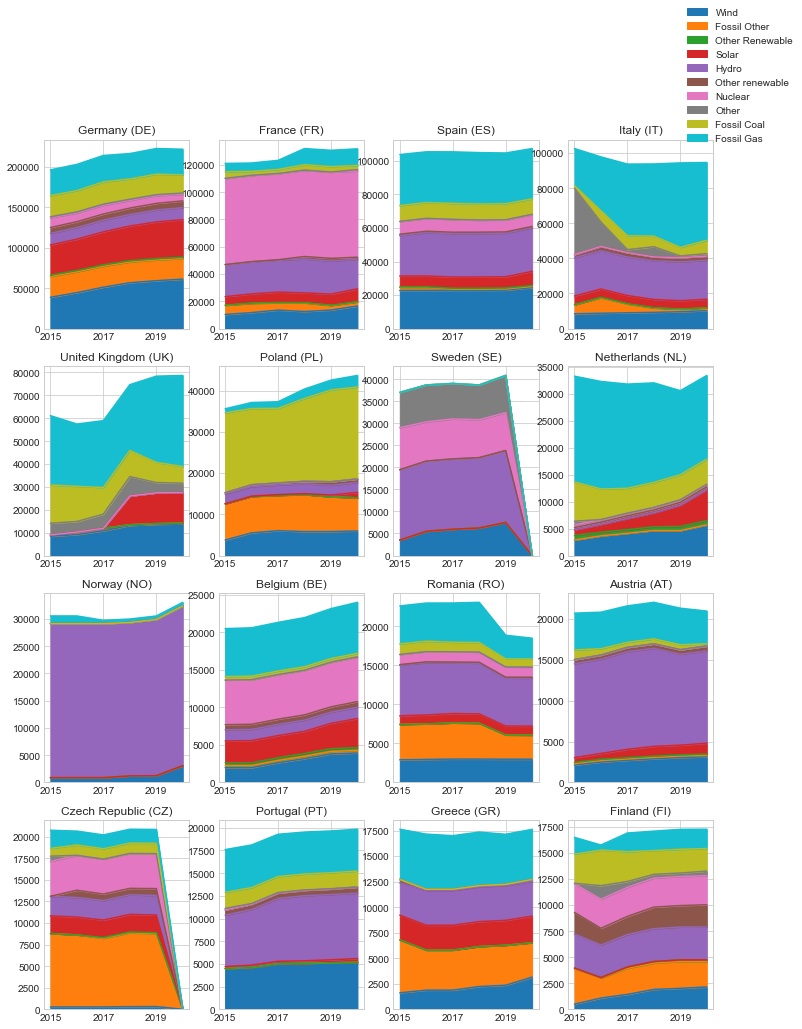

In [9]:
subplot_ncols = 4
subplot_nrows = 4
fig, ax = plt.subplots(
    ncols=subplot_ncols, nrows=subplot_nrows, figsize=(12, 4 * subplot_nrows)
)
max_caps = np.array(
    [table["Total Grand capacity"].mean() for table in cap_tables]
)
max_caps[np.isnan(max_caps)] = -1
sort_idx = np.flip(np.argsort(max_caps))
for idx, table_idx in enumerate(sort_idx[:16]):
    prep_table(cap_tables[table_idx]).plot(kind="area", ax=ax[idx // subplot_ncols, idx % subplot_ncols], title=country_names[table_idx])
    ax[idx // subplot_ncols, idx % subplot_ncols].legend_.remove()


handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='left')

plt.show()

Germany has installed a log more wind and solar power which has increased in renewables. France has increased in wind power.

The UK and Italy have both increased the uptake of fossil gas power.

Much of Scandinavia has a high percentage of renewables, mainly hydro.


Some of these changes point to issues with the data. The UK has no nuclear output listed and has no solar before 2017.